In [1]:
%load_ext autoreload
%autoreload 2

import dotenv
import os

dotenv.load_dotenv(dotenv_path="secrets.env")
hf_token = os.getenv("HUGGINGFACE_API_KEY")

import os

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import dotenv

from tasks.hp.HPTask import HPTriviaTask, HPVerbatimTask, HPVerbatimTaskTranchedByBook
from tasks.hp.HPSAQ import HPSAQ, HPSAQTranchedByBook
from tasks.hp.HPFamiliarity import HPCompletionsFamiliarity, HPFamiliarityTranchedByBook

from datetime import datetime

import tqdm
import torch

import matplotlib.pyplot as plt

In [2]:
def load_ckpt(base_model, folder, ckpt):
    peft_model = PeftModel.from_pretrained(base_model, os.path.join(folder, "checkpoint-" + str(ckpt)))
    return peft_model

In [3]:
books_to_test_on = [1, 2, 3]

# merge the files "tasks/hp/data/tranched_by_book/book_{book_num}.jsonl" into "tasks/hp/data/tranched_by_book/all.jsonl"

all_data = ""
for book_num in books_to_test_on:
    with open(f"tasks/hp/data/tranched_by_book/book_{book_num}.jsonl", "r") as f:
        all_data += f.read()

with open(f"tasks/hp/data/tranched_by_book/all.jsonl", "w") as f:
    f.write(all_data)

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/Llama2-7b-WhoIsHarryPotter",
    use_auth_token=hf_token
)

tokenizer.pad_token = tokenizer.eos_token

print(tokenizer.pad_token)

hp_familiarity_tasks = [HPFamiliarityTranchedByBook(i) for i in books_to_test_on]

hp_verbatim_task = HPVerbatimTaskTranchedByBook(8, tokenizer, books_to_test_on)

def eval_model(model):
    # hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts.json')
    # exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    # hp_familiarity_task.generate_responses(model, tokenizer, eval_onthe_fly=True, eval_model='gpt-3.5-turbo', max_new_tokens=20, temperature=0, verbose=True, n_questions=50)
    # familiarity, responses = hp_familiarity_task.get_accuracies()
    # print(responses)
    # return familiarity

    # accs = {"zero_shot": 0, "few_shot": 0, "unrelated_few_shot": 0}
    # for task in hp_saq_tasks:
    #     task.generate_responses(model, tokenizer, n_questions=10)
    #     this_accs = task.get_accuracies()
    #     accs["zero_shot"] += this_accs["zero_shot"]
    #     accs["few_shot"] += this_accs["few_shot"]
    #     accs["unrelated_few_shot"] += this_accs["unrelated_few_shot"]
    
    # accs["zero_shot"] /= len(hp_saq_tasks)
    # accs["few_shot"] /= len(hp_saq_tasks)
    # accs["unrelated_few_shot"] /= len(hp_saq_tasks)

    # return accs

    # score = 0
    # for task in hp_familiarity_tasks:
    #     task.generate_responses(model, tokenizer, eval_model='gpt-4')
    #     familiarity, responses = task.get_accuracies()
    #     score += familiarity
    #     print(responses)
    # score /= len(hp_familiarity_tasks)

    # return score

    #return hp_verbatim_task.get_test_loss(model).item()

    acc = hp_verbatim_task.get_test_loss(model, n_iters=1000).item()
    print(acc)
    return acc

/root/hp-unlrn/.env/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:711: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


</s>


/root/hp-unlrn/.env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [5]:
model_ckpts = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
model_folders = ["verbatim_finetune", "verbatim_finetune_base"]

base_models = ["hp-unlrn", "llama"]

llama_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    use_auth_token=hf_token,
    torch_dtype=torch.bfloat16
).cuda()

base_acc = eval_model(llama_model)

del llama_model

hp_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Llama2-7b-WhoIsHarryPotter",
    use_auth_token=hf_token,
    torch_dtype=torch.bfloat16
).cuda()

tokenizer.pad_token = tokenizer.eos_token

hp_acc = eval_model(hp_model)

del hp_model

all_accuracies = []

for model_folder, base_model in zip(model_folders, base_models):
    if base_model == "llama":
        accuracies = [(0, base_acc)]

        base_model = AutoModelForCausalLM.from_pretrained(
            "meta-llama/Llama-2-7b-chat-hf",
            use_auth_token=hf_token,
            torch_dtype=torch.bfloat16
        ).cuda()
    else:
        accuracies = [(0, hp_acc)]

        base_model = AutoModelForCausalLM.from_pretrained(
            "microsoft/Llama2-7b-WhoIsHarryPotter",
            use_auth_token=hf_token,
            torch_dtype=torch.bfloat16
        ).cuda()
    
    for ckpt in model_ckpts:
        print(ckpt)
        adapter = load_ckpt(base_model, model_folder, ckpt)
        acc = eval_model(base_model)
        accuracies.append((ckpt, acc))
        adapter.unload()
    
    all_accuracies.append(accuracies)

    del base_model

print(base_acc)
print(hp_acc)
print(all_accuracies)

/root/hp-unlrn/.env/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████| 1000/1000 [04:03<00:00,  4.11it/s]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]
/root/hp-unlrn/.env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


2.708958625793457


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


3.8327126502990723
1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


2.710508346557617


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

2.902005910873413
2.708958625793457
3.8327126502990723
[[(0, 3.8327126502990723), (1000, 2.710508346557617)], [(0, 2.708958625793457), (1000, 2.902005910873413)]]


2.885110378265381
600


100%|█████████████████████████████████████████████████████████████| 1000/1000 [04:02<00:00,  4.12it/s]


2.8738954067230225
700


100%|█████████████████████████████████████████████████████████████| 1000/1000 [04:03<00:00,  4.11it/s]


2.8775532245635986
800


  2%|█▍                                                             | 22/1000 [00:05<03:49,  4.26it/s]

2.7435569763183594
900


100%|███████████████████████████████████████| 1000/1000 [04:02<00:00,  4.13it/s]


2.751146078109741
1000


100%|███████████████████████████████████████| 1000/1000 [04:01<00:00,  4.14it/s]


2.750664472579956
3.036888837814331
3.4972031116485596
[[(0, 3.4972031116485596), (100, 3.28092622756958), (200, 3.0460121631622314), (300, 2.9241957664489746), (400, 2.8950257301330566), (500, 2.885110378265381), (600, 2.8738954067230225), (700, 2.8775532245635986), (800, 2.8754568099975586), (900, 2.8759214878082275), (1000, 2.8729376792907715)], [(0, 3.036888837814331), (100, 2.908545970916748), (200, 2.792257070541382), (300, 2.7728617191314697), (400, 2.762115955352783), (500, 2.7416458129882812), (600, 2.7486376762390137), (700, 2.746772050857544), (800, 2.7435569763183594), (900, 2.751146078109741), (1000, 2.750664472579956)]]


In [6]:
print("base_acc =", base_acc)
print("hp_acc =", hp_acc)
print("all_accuracies =", all_accuracies)

base_acc = 3.036888837814331
hp_acc = 3.4972031116485596
all_accuracies = [[(0, 3.4972031116485596), (100, 3.28092622756958), (200, 3.0460121631622314), (300, 2.9241957664489746), (400, 2.8950257301330566), (500, 2.885110378265381), (600, 2.8738954067230225), (700, 2.8775532245635986), (800, 2.8754568099975586), (900, 2.8759214878082275), (1000, 2.8729376792907715)], [(0, 3.036888837814331), (100, 2.908545970916748), (200, 2.792257070541382), (300, 2.7728617191314697), (400, 2.762115955352783), (500, 2.7416458129882812), (600, 2.7486376762390137), (700, 2.746772050857544), (800, 2.7435569763183594), (900, 2.751146078109741), (1000, 2.750664472579956)]]


In [7]:
# results for finetuned unlearned and chat models - FOR PAPER
base_acc = 3.036888837814331
hp_acc = 3.4972031116485596
all_accuracies = [[(0, 3.4972031116485596), (100, 3.28092622756958), (200, 3.0460121631622314), (300, 2.9241957664489746), (400, 2.8950257301330566), (500, 2.885110378265381), (600, 2.8738954067230225), (700, 2.8775532245635986), (800, 2.8754568099975586), (900, 2.8759214878082275), (1000, 2.8729376792907715)], [(0, 3.036888837814331), (100, 2.908545970916748), (200, 2.792257070541382), (300, 2.7728617191314697), (400, 2.762115955352783), (500, 2.7416458129882812), (600, 2.7486376762390137), (700, 2.746772050857544), (800, 2.7435569763183594), (900, 2.751146078109741), (1000, 2.750664472579956)]]

In [6]:
# results from prev run
base_acc_ = 0.46534305908678647
hp_acc_ = 0.32427038263675156
all_accuracies_ = [[(0, 0.32427038263675156), (100, 0.32125954361627784), (200, 0.35320556782193674), (300, 0.3950250996178836), (400, 0.3963737045958042), (500, 0.42296944927665525), (600, 0.49241389372109967), (700, 0.44076731789999557), (800, 0.5259048314673566), (900, 0.4175018492498922), (1000, 0.41718241223961816)]]

In [7]:
base_acc_ = 0.22818220519369947
hp_acc_ = 0.10280970625798212
all_accuracies_ = [[(0, 0.10280970625798212), (100, 0.1336739037888463), (200, 0.09450830140485313), (300, 0.24244359301830565), (400, 0.2220093656875266), (500, 0.15197956577266922), (600, 0.18284376330353344), (700, 0.13154533844189017), (800, 0.09663686675180927), (900, 0.1911451681566624), (1000, 0.12537249893571734)]]

In [8]:
# results on cross-entropy eval (1000 samples from books 4-7)
base_acc_ = 3.0362651348114014
hp_acc_ = 3.502548933029175
all_accuracies_ = [[(0, 3.502548933029175), (100, 3.2807469367980957), (200, 3.0449798107147217), (300, 2.9233744144439697), (400, 2.895801305770874), (500, 2.881465196609497), (600, 2.87931227684021), (700, 2.8763437271118164), (800, 2.8760416507720947), (900, 2.872117757797241), (1000, 2.8754565715789795)]]

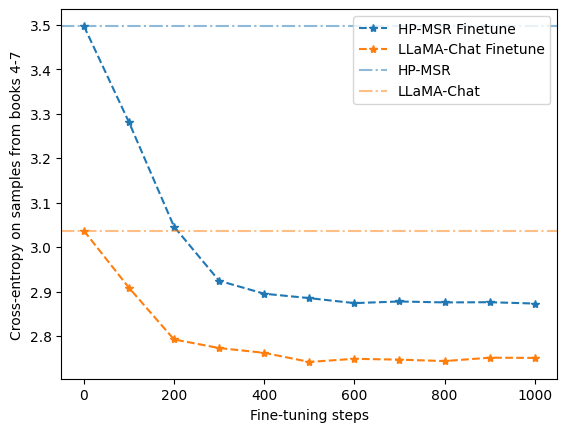

In [17]:
keys = ["zero_shot"]
line_styles = ['--', '-', '-.']

#for y, key in zip(ys, keys):
#    plt.plot(x, y, linestyle="--", marker="*", label="dpo_" + key)

labels = ["HP-MSR Finetune", "LLaMA-Chat Finetune"]
colors = ["tab:blue", "tab:orange"]

for accs, label, color in zip(all_accuracies, labels, colors):
    xs = [ckpt for ckpt, _ in accs]
    ys = [acc for _, acc in accs]
    plt.plot(xs, ys, linestyle="--", marker="*", label=label, color=color)

plt.xlabel('Fine-tuning steps')
plt.ylabel('Cross-entropy on samples from books 4-7')

#for key, line_style in zip(keys, line_styles):
#    plt.axhline(y=base_acc[key], color='r', linestyle=line_style, label="base_" + key)
#    plt.axhline(y=hp_acc[key], color='g', linestyle=line_style, label="unlearned_" + key)

plt.axhline(y=hp_acc, linestyle='-.', label="HP-MSR", color="tab:blue", alpha=0.5)
plt.axhline(y=base_acc, linestyle='-.', label="LLaMA-Chat", color="tab:orange", alpha=0.5)

plt.legend()
plt.show()

In [10]:
hp_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Llama2-7b-WhoIsHarryPotter",
    use_auth_token=hf_token,
    torch_dtype=torch.bfloat16
).cuda()